In [14]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization, GaussianNoise
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [7]:
# Định nghĩa đường dẫn dataset
processed_data_dir = "C:/Users/VuongPham/Documents/asl_alphabet/processed_data"
test_dir = "C:/Users/VuongPham/Documents/asl_alphabet/test_data"

# Cấu hình dataset
labels = ["K", "L", "M", "N", "O"]
img_size = (224, 224)
batch_size = 64

In [8]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.3,
    height_shift_range=0.3,
    zoom_range=0.3,
    brightness_range=[0.6, 1.4],
    horizontal_flip=True,
    fill_mode='nearest'
)

train_generator = train_datagen.flow_from_directory(
    processed_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    seed=42
)

val_generator = train_datagen.flow_from_directory(
    processed_data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    seed=42
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 19912 images belonging to 5 classes.
Found 4974 images belonging to 5 classes.
Found 2544 images belonging to 5 classes.


In [9]:
# Load MobileNetV2
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Đóng băng mô hình gốc

# Xây dựng mô hình mới
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = GaussianNoise(0.1)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(len(labels), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

# Biên dịch mô hình
model.compile(
    optimizer=Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Hiển thị kiến trúc mô hình
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,620,485 (10.00 MB)

 Trainable params: 361,989 (1.38 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

In [10]:
# Huấn luyện
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[early_stopping, lr_scheduler] 
)

# Lưu mô hình
model.save("mobilenetv2_model.h5")

C:\Users\VuongPham\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 671s 2s/step - accuracy: 0.6722 - loss: 0.9661 - val_accuracy: 0.8291 - val_loss: 0.4942 - learning_rate: 5.0000e-04
Epoch 2/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 545s 2s/step - accuracy: 0.8801 - loss: 0.3225 - val_accuracy: 0.8333 - val_loss: 0.4878 - learning_rate: 5.0000e-04
Epoch 3/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.9059 - loss: 0.2559 - val_accuracy: 0.8488 - val_loss: 0.4362 - learning_rate: 5.0000e-04
Epoch 4/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 528s 2s/step - accuracy: 0.9173 - loss: 0.2207 - val_accuracy: 0.8667 - val_loss: 0.3587 - learning_rate: 5.0000e-04
Epoch 5/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 530s 2s/step - accuracy: 0.9235 - loss: 0.2066 - val_accuracy: 0.8601 - val_loss: 0.3890 - learning_rate: 5.0000e-04
Epoch 6/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.9256 - loss: 0.1986 - val_accuracy: 0.8587 - val_loss: 0.4138 - learning_rate: 5.0000e-04
Epoch 7/20
312/312 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - acc

Validation Accuracy: 86.01%
Test Accuracy: 95.79%


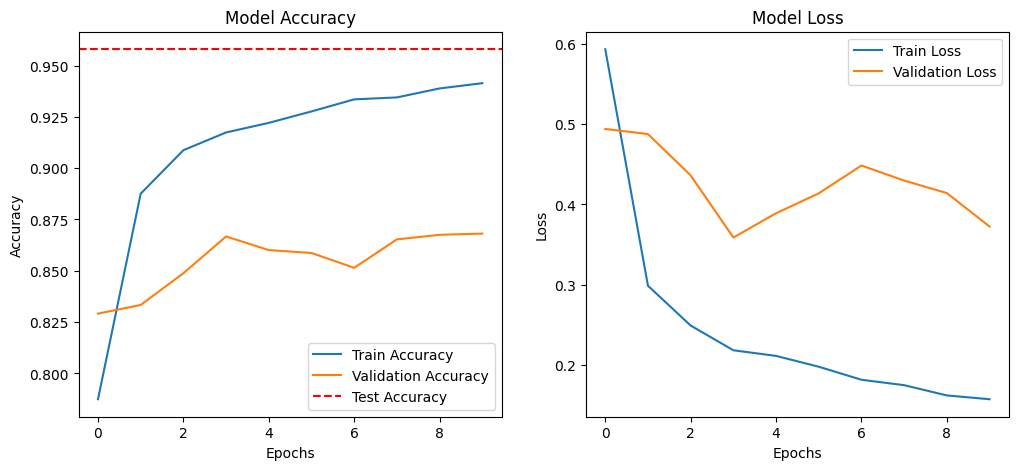

In [15]:
# Đánh giá mô hình
val_score = model.evaluate(val_generator, verbose=0)
test_score = model.evaluate(test_generator, verbose=0)
print(f'Validation Accuracy: {val_score[1] * 100:.2f}%')
print(f'Test Accuracy: {test_score[1] * 100:.2f}%')

# Vẽ biểu đồ độ chính xác và loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.axhline(y=test_score[1], color='r', linestyle='--', label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()